In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression # modelos lineales
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score #protocolo de evaluación
from sklearn import datasets, metrics
from sklearn import preprocessing
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

In [84]:
col_Headers = ["EventType","RegisterDate","StopID","Odometer","Longitude","Latitude", "TaskID","LineID","TripID","DatagramID","DatagramTimestamp","BusID"]
missing_values = ["n/a", "na", "--", "NaT","%WARN%"]
df = pd.read_csv('m_datagrams.csv',',',dtype={"EventType": str, "RegisterDate": str, "StopID": str,"Odometer": str,"Longitude": str,"Latitude": str, "TaskID": str,"LineID": str,"TripID": str,"DatagramID": str,"DatagramTimestamp": str,"BusID": str},names = col_Headers, na_values = missing_values)

In [85]:
df['DatagramTimestamp']= pd.to_datetime(df['DatagramTimestamp']) 
df['DatagramDate'] = pd.to_datetime(df['DatagramTimestamp']).dt.date
df['DatagramTime'] = pd.to_datetime(df['DatagramTimestamp']).dt.time
df = df.drop('DatagramTimestamp',1)
col_Headers = ["EventType","RegisterDate","StopID","Odometer","Longitude","Latitude", "TaskID","LineID","TripID","DatagramID","DatagramDate","DatagramTime","BusID"]
df = df[col_Headers]
df['DatagramDate'] = pd.to_datetime(df.DatagramDate)
df['RegisterDate'] = pd.to_datetime(df.RegisterDate)
df['Odometer'] = pd.to_numeric(df.Odometer, downcast ='signed')
df['Longitude'] = pd.to_numeric(df.Longitude, downcast ='signed') 
df['Latitude'] = pd.to_numeric(df.Latitude, downcast ='signed') 

## Analisis Exploratorio de Datos

Un análisis exploratorio de los datos verificando la calidad de los datos (tipos de las variables, valores inválidos, excepciones, valores faltantes, etc.), utilizando gráficos para poder entender las distribuciones de los datos e identificar posibles problemas.

In [4]:
df.head()

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
0,19,2018-09-04,501051,1,-764871900,34451717,572,140,548,5661359158,2018-09-03,07:05:57,714
1,19,2018-09-04,502103,1063,-765463867,33977717,1023,217,882,5661362653,2018-09-03,07:07:19,311
2,7,2018-09-04,515152,24,-765076783,34191300,705,2471,43,5661362655,2018-09-03,07:07:19,796
3,19,2018-09-04,502650,788,-764913067,34220317,143,150,389,5661367800,2018-09-03,07:09:21,561
4,7,2018-09-04,515006,91,-765005167,34115933,705,2471,43,5661348896,2018-09-03,07:01:54,796


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242473 entries, 0 to 2242472
Data columns (total 13 columns):
EventType       object
RegisterDate    datetime64[ns]
StopID          object
Odometer        float64
Longitude       float64
Latitude        float64
TaskID          object
LineID          object
TripID          object
DatagramID      object
DatagramDate    datetime64[ns]
DatagramTime    object
BusID           object
dtypes: datetime64[ns](2), float64(3), object(8)
memory usage: 222.4+ MB


In [87]:
data_missing= df.isnull().sum()/len(df)*100
data_missing

EventType        0.000000
RegisterDate    31.830350
StopID           0.000089
Odometer         0.000089
Longitude        0.000089
Latitude         0.000089
TaskID           0.000089
LineID           0.000089
TripID           0.000089
DatagramID       0.000089
DatagramDate    32.079494
DatagramTime    32.079494
BusID            0.000089
dtype: float64

In [7]:
df.tail()

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
2242468,8,2018-06-29,502301,-1,-765284850,34415983,145,2104,165,5511316915,2018-06-28,15:44:47,30
2242469,5,2018-06-29,502551,597,-765102900,34897600,931,2274,491,5511337393,2018-06-28,15:54:22,69
2242470,8,2018-06-29,502551,597,-1,-1,931,2274,491,5511337432,2018-06-28,15:54:23,69
2242471,WARN: The method class org.apache.commons.logg...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2242472,WARN: Please see http://www.slf4j.org/codes.ht...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [8]:
df.describe(include="all")

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
count,2242473,1528686,2242471,2242471,2242471,2242471,2242471,2242471,2242471,2242471,1523099,1523099,2242471
unique,34,243,2120,12571,65753,108930,4304,111,2798,2242471,242,75959,853
top,7,2019-03-30,-1,-1,-1,-1,-1,2273,-1,5652103765,2019-03-14 00:00:00,07:14:58,147
freq,320439,11502,78210,524456,76703,76703,62608,101770,64520,1,12400,64,52793
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-31 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-30 00:00:00,NaN,NaN


# Limpieza de Datos
Se realiza una limpieza de datos para poder iniciar a interpretar el comportamiento de los datos.
Para esto procedemos a realizar las siguientes operaciones:
- Hallar el porcentaje de Missing Values
- Buscar y eliminar los datos duplicados
- Eliminar los valores nulos que se encuentren en los datos

### Missing Values

Standard Type = NaN,"", "%WARN%"


Estos son los missing values reconocidos en el Dataset

#### Los -1 y los 0 son buses que van sin tarea, sin operación, son viajes de posicionamiento o de salida

In [21]:
df[df['DatagramDate'] == '-1']

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID


In [88]:
print("Porcentajes de -1 por cada columna : ")
i=0
for a in df.columns:
    if a == 'DatagramDate':
        print(a,":",0/len(df)*100,"%")
    else:
        print(a,":",(df[a].values=='-1').sum()/len(df)*100,"%")
    i+=1

Porcentajes de -1 por cada columna : 
EventType : 0.0 %


AttributeError: 'bool' object has no attribute 'sum'

### Busqueda de Valores Duplicados

In [11]:
duplicateDFRow = df[df.duplicated()]
print(duplicateDFRow)

Empty DataFrame
Columns: [EventType, RegisterDate, StopID, Odometer, Longitude, Latitude, TaskID, LineID, TripID, DatagramID, DatagramDate, DatagramTime, BusID]
Index: []


### Eliminación de valores Nulos

In [12]:
df =df.dropna()

In [23]:
df2= df[(df['EventType']=='12') | (df['EventType']=='23')]
df2 = df2.sort_values(by=['DatagramDate'])
df2.head()

,EventType,RegisterDate,StopID,Odometer,Longitude,Latitude,TaskID,LineID,TripID,DatagramID,DatagramDate,DatagramTime,BusID
974735,23,2018-05-31,516139,860,-765249767,33851300,779,2212,3,5444475832,2018-05-31,04:54:52,640
462488,23,2018-06-01,514026,33,-764679667,34357783,864,3411,168,5448932853,2018-05-31,13:17:13,926
462508,12,2018-06-01,501855,15,-765482183,34155650,178,421,238,5448941807,2018-05-31,13:22:12,959
974729,23,2018-05-31,502650,17,-764905867,34213800,129,2842,445,5444468262,2018-05-31,04:50:09,158
974728,23,2018-05-31,514071,1,-764776233,34247217,861,2842,18,5444465444,2018-05-31,04:48:17,151


In [24]:
temp= df2.BusID.value_counts().to_frame()
BusIDCounts= temp.reset_index()
BusIDCounts.columns=['BusID','Counts']
BusIDCounts.head()

,BusID,Counts
0,255,8585
1,640,6097
2,571,5817
3,153,4602
4,638,4014


In [25]:
plt.rc('figure',figsize=(15,8))

In [ ]:
x = BusIDCounts['BusID']
y = BusIDCounts['Counts']

fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel("BusID")
ax.set_ylabel("Event Count")
ax.set_title('BusID vs EventType (12-23) Count')
plt.show()

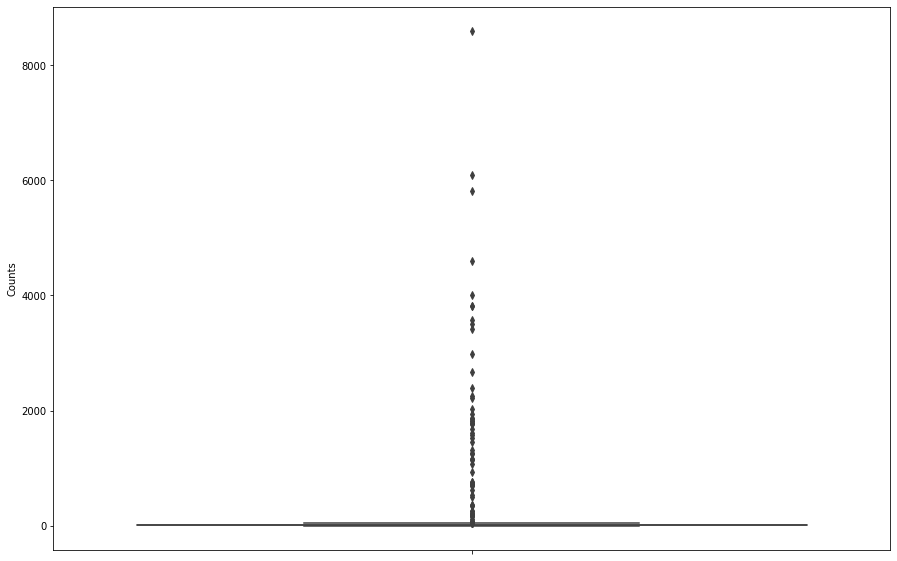

In [56]:
sns.boxplot(y=BusIDCounts['Counts'])

In [28]:
BusIDCounts[BusIDCounts['Counts'] < 4000]

,BusID,Counts
5,642,3818
6,158,3808
7,150,3569
8,147,3500
9,132,3420
10,156,2987
11,151,2671
12,135,2399
13,169,2247
14,1095,2223


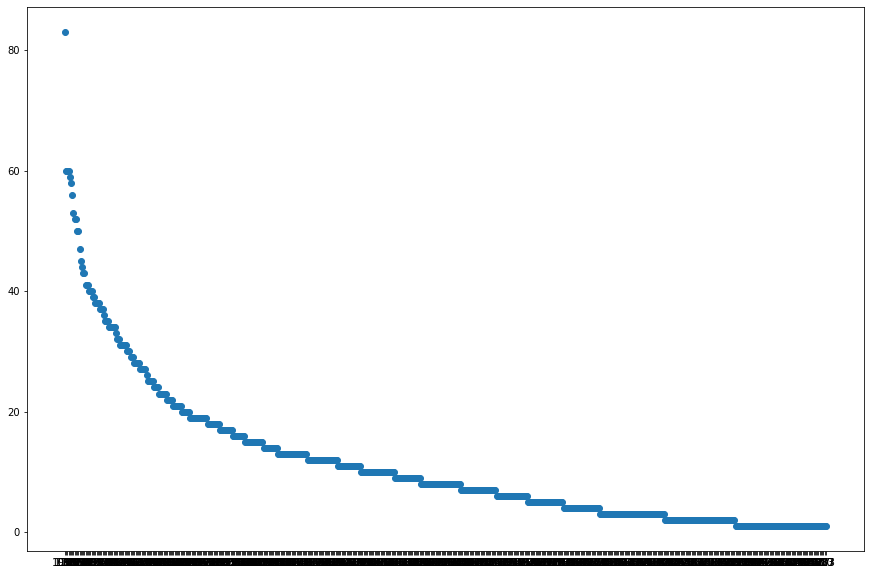

In [67]:
BusIDCounts2 = BusIDCounts[BusIDCounts['Counts'] < 100]
x2 = BusIDCounts2['BusID']
y2 = BusIDCounts2['Counts']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax.set_xlabel("BusID")
ax.set_ylabel("Event Count")
ax.set_title('BusID vs EventType (12-23) Count < 100')
plt.show()


In [30]:
temp= df2.BusID.value_counts().to_frame()
BusIDCounts= temp.reset_index()
BusIDCounts.columns=['BusID','Counts']
BusIDCounts2 = BusIDCounts[BusIDCounts['Counts'] < 100]
BusIDCounts2.head()

,BusID,Counts
58,1093,83
59,1107,60
60,960,60
61,1171,60
62,788,59


# Buses selected to graph
- Bus Id: 255  --> EventCount = 8585
- Bus Id: 640  --> EventCount = 6097
- Bus Id: 571  --> EventCount = 5817
- Bus Id: 132 --> EventCount = 3420
- Bus Id: 135 --> EventCount = 2399
- Bus Id: 898 --> EventCount = 1824
- Bus Id: 1093 --> EventCount = 83 
- Bus Id: 1171 --> EventCount = 60
- Bus Id: 1107 --> EventCount = 60

## Bus 255

### General View: 

In [31]:
dfBus1 = df2[(df2['BusID'] == '255')]
dfBus1_1 = dfBus1['DatagramDate'].drop_duplicates().to_frame()
dfBus1_1

,DatagramDate
974710,2018-05-31
587398,2018-06-01
2065321,2018-06-02
77923,2018-06-03
960008,2018-06-04
2065691,2018-06-05
590231,2018-06-06
77402,2018-06-07
688112,2018-06-08
1001692,2018-06-09


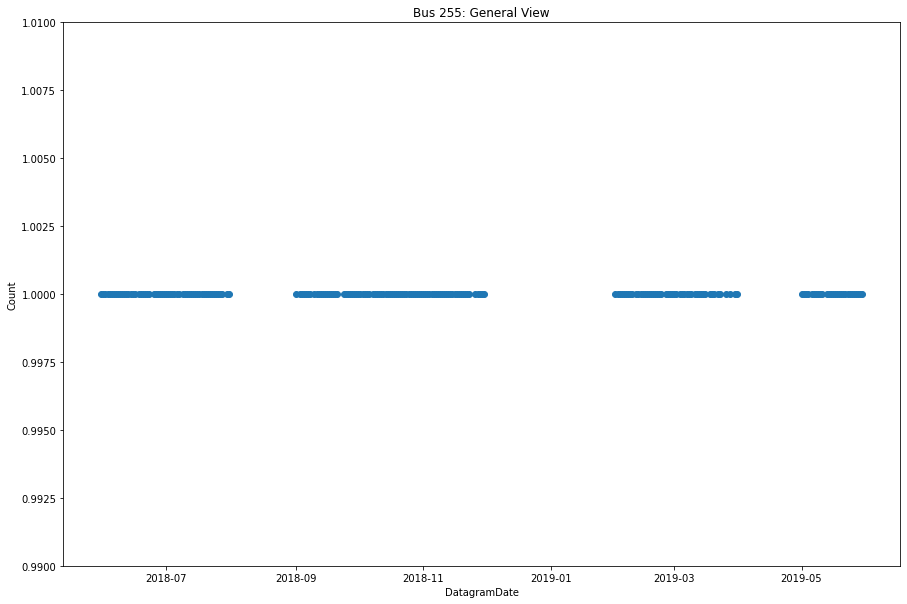

In [66]:
size = dfBus1_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus1_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 255: General View")
plt.ylim(0.99,1.01)
plt.show()

In [ ]:
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus1_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 255: General View")
plt.ylim(0.99,1.01)
plt.show()

## Bus 640

### General View: 

In [68]:
dfBus2 = df2[(df2['BusID'] == '640')]
dfBus2_1 = dfBus2['DatagramDate'].drop_duplicates().to_frame()
dfBus2_1

,DatagramDate
974735,2018-05-31
429333,2018-06-01
693799,2018-06-02
307856,2018-06-03
307047,2018-06-04
1247081,2018-06-05
590252,2018-06-06
312208,2018-06-08
309347,2018-06-09
594404,2018-06-10


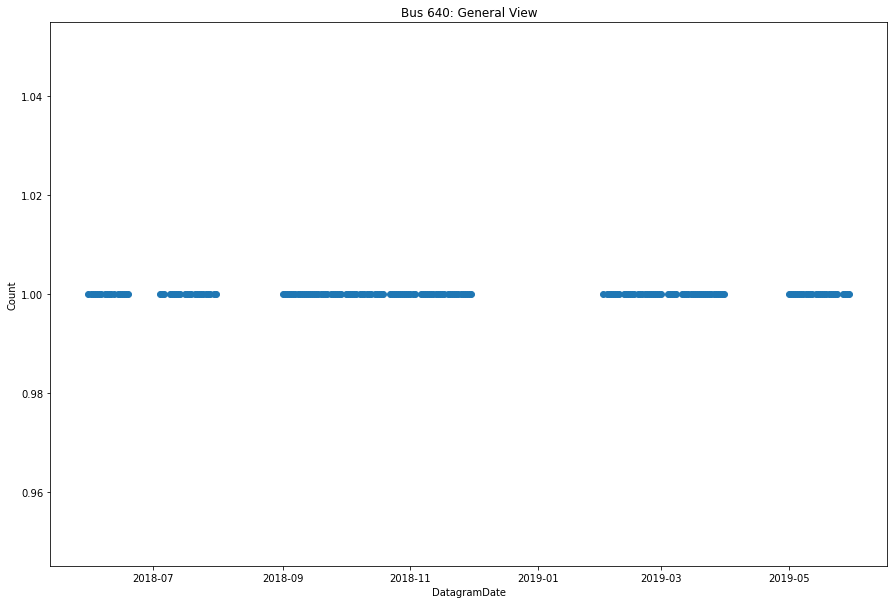

In [69]:
size = dfBus2_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus2_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 640: General View")
plt.show()

## Bus 571

### General View: 

In [70]:
dfBus3 = df2[(df2['BusID'] == '571')]
dfBus3_1 = dfBus3['DatagramDate'].drop_duplicates().to_frame()
dfBus3_1

,DatagramDate
462727,2018-05-31
429420,2018-06-01
1097683,2018-06-02
594189,2018-06-04
959426,2018-06-05
959512,2018-06-06
1101258,2018-06-07
996795,2018-06-08
690324,2018-06-09
77748,2018-06-10


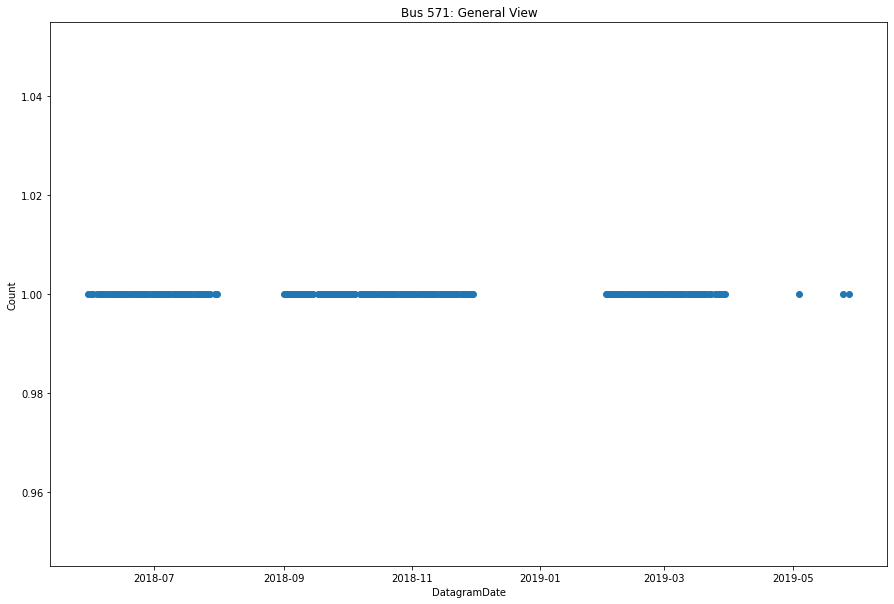

In [71]:
size = dfBus3_1.size
plt.rc('figure',figsize=(15,10))
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus3_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 571: General View")
plt.show()

## Bus 132

### General View: 

In [72]:
dfBus4 = df2[(df2['BusID'] == '132')]
dfBus4_1 = dfBus4['DatagramDate'].drop_duplicates().to_frame()
dfBus4_1

,DatagramDate
429784,2018-06-01
31319,2018-06-04
996022,2018-06-05
1096814,2018-06-06
1101191,2018-06-07
28485,2018-06-11
999860,2018-06-12
588591,2018-06-14
2077242,2018-06-15
103328,2018-06-16


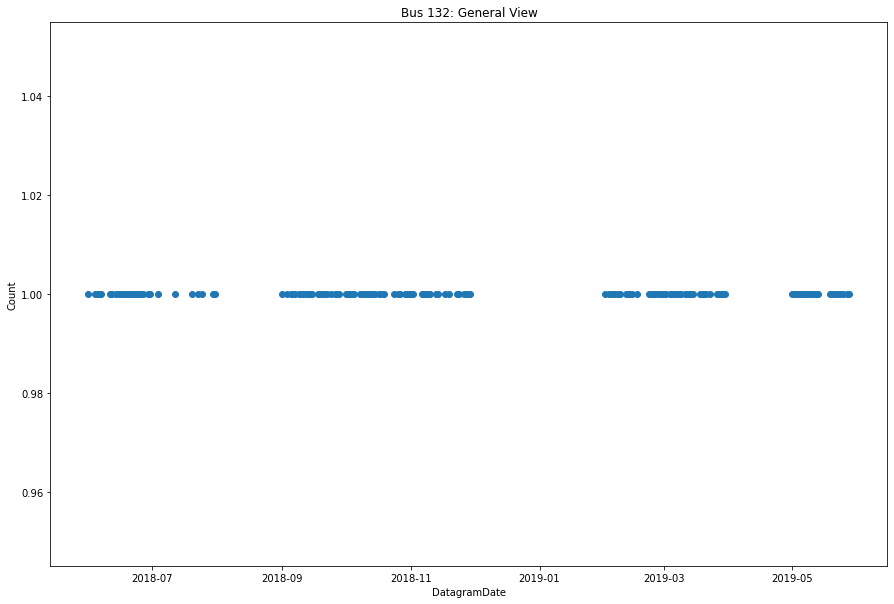

In [73]:
size = dfBus4_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus4_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 132: General View")
plt.show()

## Bus 135

### General View: 

In [74]:
dfBus5 = df2[(df2['BusID'] == '135')]
dfBus5_1 = dfBus5['DatagramDate'].drop_duplicates().to_frame()
dfBus5_1

,DatagramDate
566720,2018-10-08
2013358,2019-02-01
1600572,2019-02-02
1701180,2019-02-03
1118301,2019-02-04
644708,2019-02-05
1325742,2019-02-06
635574,2019-02-07
651701,2019-02-08
355044,2019-02-09


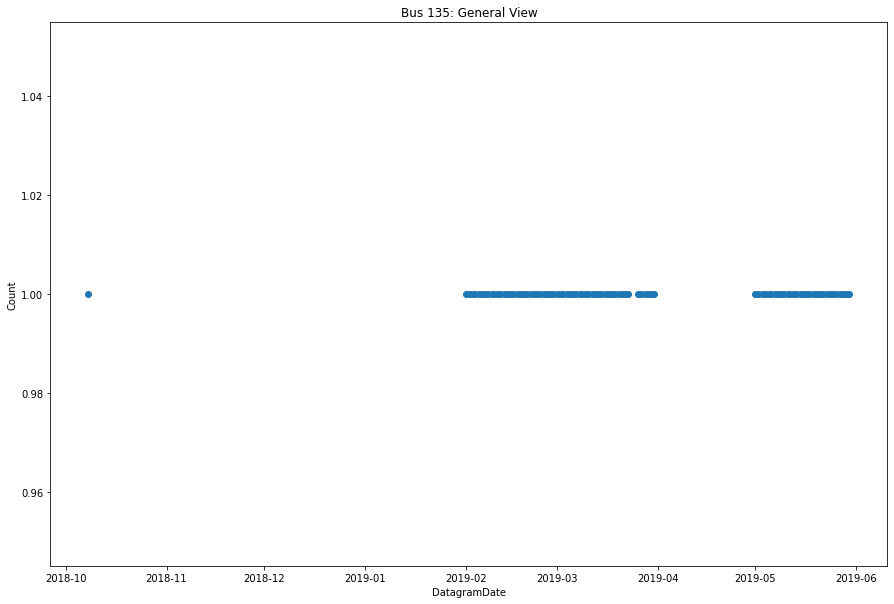

In [75]:
size = dfBus5_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus5_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 135: General View")
plt.show()

## Bus 898

### General View: 

In [76]:
dfBus6 = df2[(df2['BusID'] == '898')]
dfBus6_1 = dfBus6['DatagramDate'].drop_duplicates().to_frame()
dfBus6_1

,DatagramDate
975421,2018-05-31
430824,2018-06-01
957281,2018-06-02
308007,2018-06-03
309101,2018-06-04
1246955,2018-06-05
957877,2018-06-06
1096175,2018-06-07
297640,2018-06-08
996647,2018-06-09


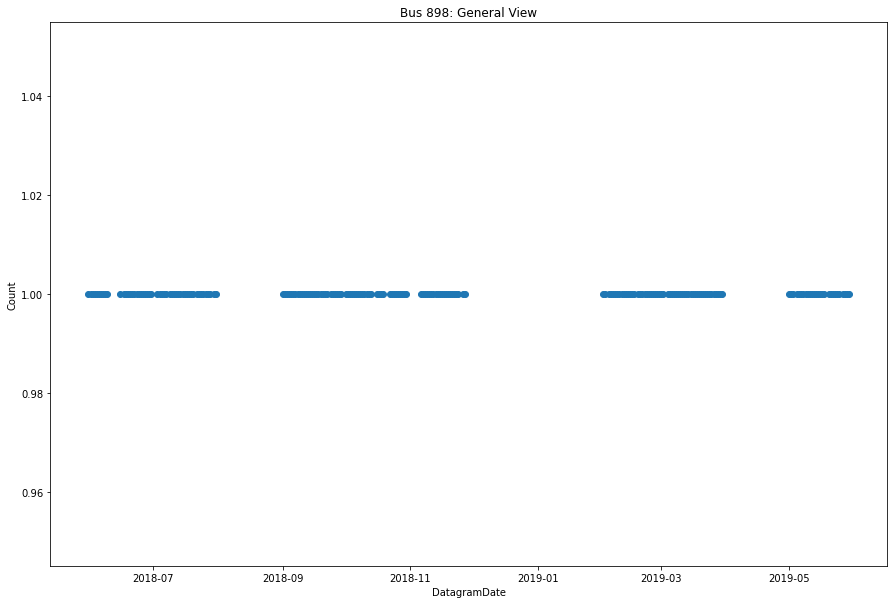

In [77]:
size = dfBus6_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus6_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 898: General View")
plt.show()

## Bus 1093

### General View: 

In [78]:
dfBus7 = df2[(df2['BusID'] == '1093')]
dfBus7_1 = dfBus7['DatagramDate'].drop_duplicates().to_frame()
dfBus7_1

,DatagramDate
958993,2018-06-02
686906,2018-06-09
1242340,2018-06-11
690974,2018-06-13
97015,2018-06-25
1164105,2018-07-03
34496,2018-07-04
15272,2018-07-08
2018970,2018-07-14
682166,2018-07-19


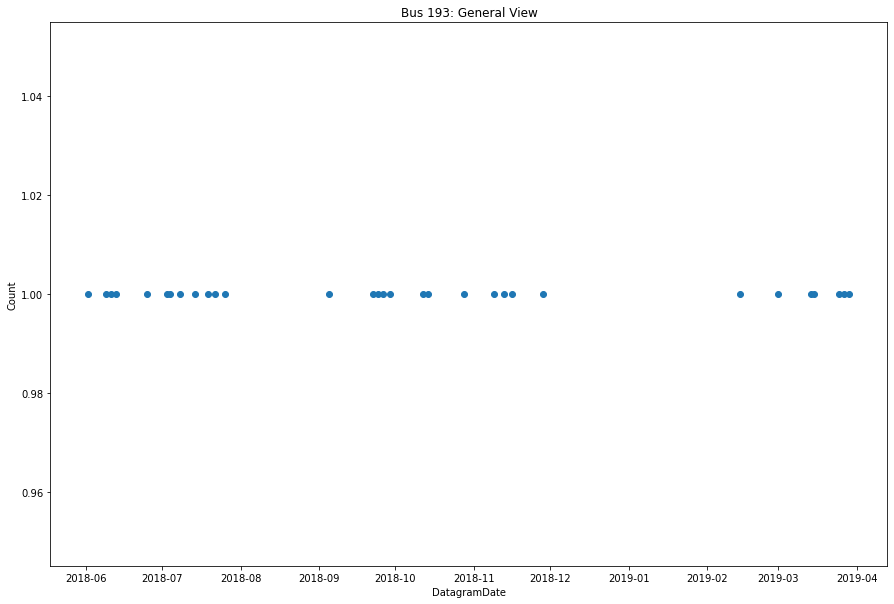

In [79]:
size = dfBus7_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus7_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 193: General View")
plt.show()

## Bus 1171

### General View: 

In [80]:
dfBus8 = df2[(df2['BusID'] == '1171')]
dfBus8_1 = dfBus8['DatagramDate'].drop_duplicates().to_frame()
dfBus8_1

,DatagramDate
587006,2018-06-07
1252729,2018-07-06
7320,2018-09-15
246094,2018-11-22
1974712,2018-11-23
2033331,2019-02-13
656797,2019-02-14
1504916,2019-02-15
333363,2019-02-23
793342,2019-02-25


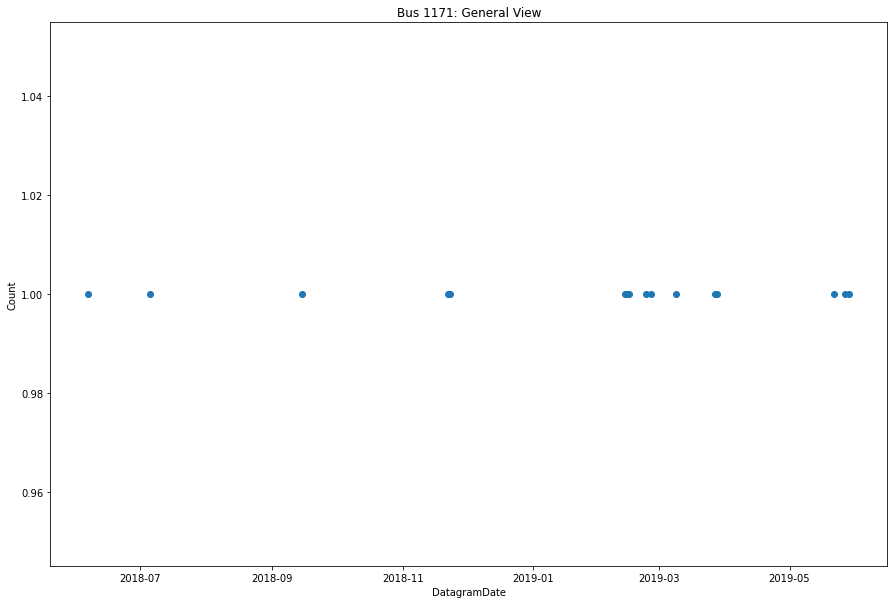

In [81]:
size = dfBus8_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus8_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 1171: General View")
plt.show()

## Bus 1107

### General View:

In [82]:
dfBus9 = df2[(df2['BusID'] == '1107')]
dfBus9_1 = dfBus9['DatagramDate'].drop_duplicates().to_frame()
dfBus9_1

,DatagramDate
103263,2018-06-22
104522,2018-06-29
1166453,2018-07-05
549789,2018-07-15
39638,2018-07-18
2061313,2018-07-19
955276,2018-07-24
1415258,2018-09-03
1680639,2018-09-06
226105,2018-09-12


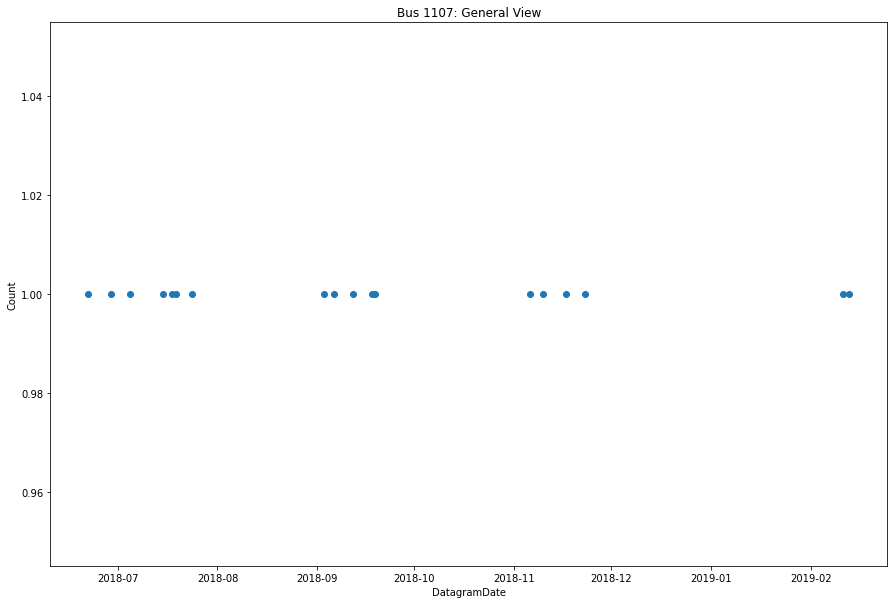

In [83]:
size = dfBus9_1.size
y2 = [(x/x) for x in range (1,size+1)]
x2 = dfBus9_1['DatagramDate']
fig,ax2 = plt.subplots()
ax2.scatter(x2,y2)
ax2.set_xlabel("DatagramDate")
ax2.set_ylabel("Count")
ax2.set_title("Bus 1107: General View")
plt.show()